<a href="https://colab.research.google.com/github/emichester/07MIAR_Redes_Neuronales_y_Deep_Learning/blob/main/PortfolioImplementacionArticuloCientifico/07MIAR_Codigo_de_Articulo_Cientifico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad Portafolio Artículo Científico

Alumno: [Emilio Jesús Hernández Salas](mailto:emiliohersal@gmail.com)

## Drive

In [1]:
# SOLO PARA USO EN GOOGLE COLABORATORY
# Para conectar el notebook con la cuenta de gdrive
from google.colab import drive
import os
import shutil
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
BASE_PATH = "/content/drive/My Drive/ASIGNATURAS/VIU/07MIAR_Redes_Neuronales_y_Deep_Learning/"
WORKSPACE_PATH = os.path.join(BASE_PATH,'Articulo_Cientifico')

In [3]:
if not os.path.exists(WORKSPACE_PATH):
    os.mkdir(WORKSPACE_PATH)

shutil.copyfile(os.path.join(BASE_PATH,'ProyectoProgramacionFinal','kaggle.json'), 'kaggle.json')

'kaggle.json'

## Kaggle

In [4]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=65d75e270a3669a9209cd0c51c09ece6ad62877c612290ff2a00e3d41decdc9d
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [5]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d balraj98/massachusetts-roads-dataset

100% 5.76G/5.76G [00:37<00:00, 245MB/s]
100% 5.76G/5.76G [00:37<00:00, 164MB/s]


In [7]:
# Creemos un directorio para descomprimir los datos
!mkdir my_dataset

In [8]:
!unzip -o -q massachusetts-roads-dataset.zip -d my_dataset

## Imports

In [3]:
import matplotlib.pyplot as plt

## Dataset

In [4]:
DATA_DIR = 'my_dataset/tiff/'

train_dir = os.path.join(DATA_DIR, 'train')
mask_dir = os.path.join(DATA_DIR, 'train_labels')
val_dir = os.path.join(DATA_DIR, 'val')
v_mask_dir = os.path.join(DATA_DIR, 'val_labels')

test_dir = os.path.join(DATA_DIR, 'test')
t_mask_dir = os.path.join(DATA_DIR, 'test_labels')

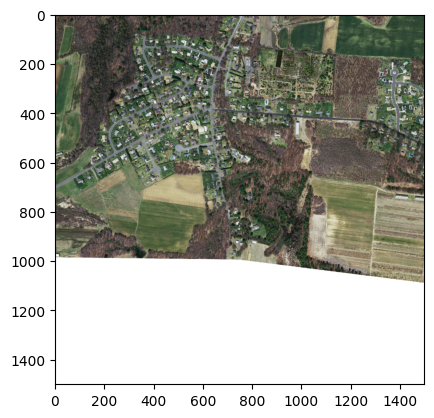

In [5]:
img_path = train_dir+'/10078660_15.tiff'
img = plt.imread(img_path)
plt.imshow(img);

In [6]:
img.shape

(1500, 1500, 3)

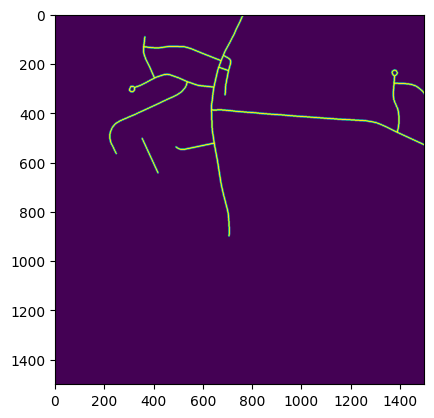

In [7]:
label_path = mask_dir+'/10078660_15.tif'
label = plt.imread(label_path)
plt.imshow(label);

In [8]:
label.shape

(1500, 1500)

## Preprocessing, metric and others

reused from [U-Net for Road Segmentation_Keras_vs1](https://www.kaggle.com/code/danielwander/u-net-for-road-segmentation-keras-vs1)

- The generator is not appropriate, it overloads the RAM memory, it would be better to user `flow_from_directory` or `flow_from_dataframe`

### Needed imports

In [9]:
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, MaxPooling2D, Concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import cv2
import os, random
import matplotlib.pyplot as plt

K.set_image_data_format('channels_last')

### Functions

In [10]:
def preprocess_mask_image2(image, class_num, color_limit):
  pic = np.array(image)
  img = np.zeros((pic.shape[0], pic.shape[1], 1))
  np.place(img[ :, :, 0], pic[ :, :, 0] >= color_limit, 1)
  return img

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims):
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) / 2

    if padding<0:
        return image

    return image[padding:image_size - padding, padding:image_size - padding, :]

#Generator for training
def train_generator(img_dir, label_dir, batch_size, input_size, p_dataset = 1):
    list_images = os.listdir(label_dir)

    #select the list elements
    if p_dataset == 1:
      ids_train_split = range(len(list_images))
    else:
      random_list = random.choices(list_images, k = int(p_dataset*(len(list_images))))
      ids_train_split = range(len(random_list))

    #generate the batch elements
    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]

            for id in ids_train_batch:
              img_name = os.path.join(img_dir, list_images[id] + 'f')
              mask_name = os.path.join(label_dir, list_images[id])


              img = cv2.imread(img_name)
              img  = cv2.resize(img, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)

              mask = cv2.imread(mask_name)
              mask = cv2.resize(mask, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)
              mask = preprocess_mask_image2(mask, 2, 50)

              x_batch += [img]
              y_batch += [mask]


            x_batch = np.array(x_batch) / 255.
            y_batch = np.array(y_batch)

            yield x_batch, np.expand_dims(y_batch, -1)

#generate the batch elements whitout the outliers
def train_generator_vs2(img_dir, label_dir, batch_size, input_size, outliers_list, p_dataset = 1):
    list_images = os.listdir(label_dir)

    #select the list elements
    if p_dataset == 1:
      ids_train_split = range(len(list_images))
    else:
      random_list = random.choices(list_images, k = int(p_dataset*(len(list_images))))
      ids_train_split = range(len(random_list))

    #generate the batch elements
    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]

            for id in ids_train_batch:

              if list_images[id].split('.')[0] not in outliers_list:
                  img_name = os.path.join(img_dir, list_images[id] + 'f')
                  mask_name = os.path.join(label_dir, list_images[id])

                  img = cv2.imread(img_name)
                  img  = cv2.resize(img, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)

                  mask = cv2.imread(mask_name)
                  mask = cv2.resize(mask, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)
                  mask = preprocess_mask_image2(mask, 2, 50)

                  x_batch += [img]
                  y_batch += [mask]


            x_batch = np.array(x_batch) / 255.
            y_batch = np.array(y_batch)

            yield x_batch, np.expand_dims(y_batch, -1)

#Generator for test phase
def test_generator(img_dir, label_dir, batch_size, input_size, p_dataset = 1):
    list_images = os.listdir(label_dir)

    #select the list elements
    if p_dataset == 1:
      ids_train_split = range(len(list_images))
    else:
      random_list = random.choices(list_images, k = int(p_dataset*(len(list_images))))
      ids_train_split = range(len(random_list))

    #generate the batch elements
    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]

            for id in ids_train_batch:
              img_name = os.path.join(img_dir,list_images[id]+'f')
              mask_name = os.path.join(label_dir, list_images[id])

              img = cv2.imread(img_name)
              img  = cv2.resize(img, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)

              mask = cv2.imread(mask_name)
              mask = cv2.resize(mask, (input_size[0], input_size[1]), interpolation=cv2.INTER_AREA)
              mask = preprocess_mask_image2(mask, 2, 50)

              x_batch += [img]
              y_batch += [mask[:,:,0]]


            x_batch = np.array(x_batch) / 255.
            y_batch = np.array(y_batch)

            yield x_batch, np.expand_dims(y_batch, -1)


#Resize and normalize the test img
def prepare_test_image(image):
  x_batch = []
  # img = cv2.imread(image_path)
  img  = cv2.resize(image, image_shape, interpolation=cv2.INTER_AREA)
  x_batch += [img]
  x_batch = np.array(x_batch) / 255.

  return x_batch

#Convert an image to binary
def binaryImage(image):
  x = image.shape[1]
  y = image.shape[2]
  imgs = np.zeros((x,y,3))
  for k in range(x):
    for n in range(y):
      if image[0,k,n]>0.5:
        imgs[k,n,0]=255
        imgs[k,n,1]=255
        imgs[k,n,2]=255
        # print(imgs[k,n])
      # else:
      #   imgs[k,n]=0
  return imgs

#Draw Function
def draw(orig_im, mask_im, recogn_im, out_im):
  plt.figure(figsize=(20,17))
  plt.subplot(1,4,1)
  plt.title('Original')
  plt.imshow(orig_im)
  plt.subplot(1,4,2)
  plt.title('Mask Original')
  plt.imshow(mask_im)
  plt.subplot(1,4,3)
  plt.title('Recogn Roads')
  plt.imshow(recogn_im)
  plt.subplot(1,4,4)
  plt.title('Out Unet')
  plt.imshow(out_im)
  plt.axis('off')
  plt.show()

#Prediction with test images
def recogn_test_image(p_dataset = 1):
  test_images = os.listdir(t_mask_dir)
  nr_samples = int(len(test_images)*p_dataset)

  # Selecionar N números aleatórios sem repetição da lista
  test_sample = random.sample(test_images, nr_samples)

  for test in test_sample:
    im_test = cv2.imread(os.path.join(test_dir,test+'f'))
    im_mask = cv2.imread(os.path.join(t_mask_dir,test))
    out_test = model.predict(prepare_test_image(im_test), verbose=0)
    img_r = binaryImage(out_test)
    draw(im_test, im_mask, img_r, out_test[0,:, :, 0]*255)

### Other definitions

In [11]:
Outliers = []

### Hyperparameters

In [16]:
#Hyperparameters
batch_size = 2
LR = 0.0001
Optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

Loss_FN = 'binary_crossentropy'

Epochs = 100
Perc_DS = 0.1

#Steps per Epoch:
X_train = os.listdir(train_dir)
SPE = (len(X_train)*Perc_DS)/batch_size

Act_Fn = 'relu'

IMG_HEIGHT = 224#1024
IMG_WIDTH  = 224#1024
IMG_CHANNELS = 3

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
image_shape = (IMG_HEIGHT, IMG_WIDTH)

## Model (my own model implementation)

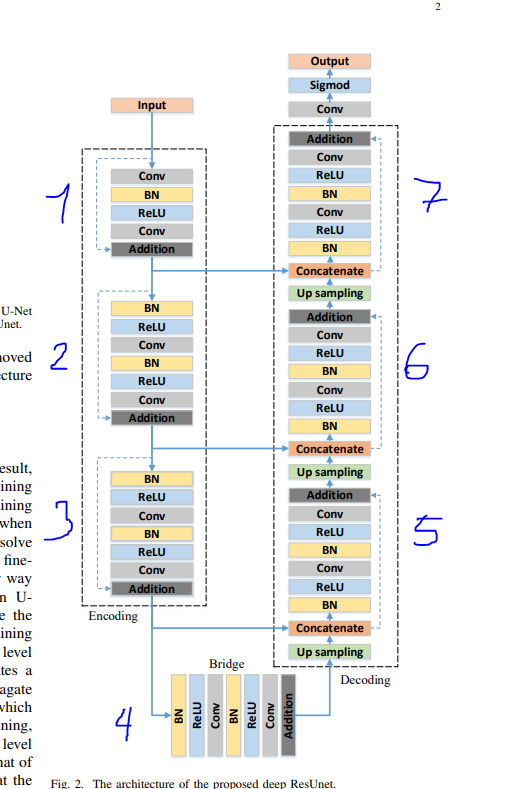

### Model definition

- [Add layer usage](https://github.com/edwinpalegre/EE8204-ResUNet/blob/master/model_resunet.py)

```python
res_conn = Conv2D(conv_filter, kernel_size=(1,1), strides=stride[0], padding='same')(feature_map)
res_conn = BatchNormalization()(res_conn)
addition = Add()([res_conn, conv_2])
```

In [13]:
input = Input(shape=input_shape)

# Encoder
# Block 1
x1 = Conv2D(64, (3,3), padding='same')(input)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Conv2D(64, (3,3), padding='same')(x1)
# residual connection # https://github.com/edwinpalegre/EE8204-ResUNet/blob/master/model_resunet.py
res_conn = Conv2D(64, (1,1), padding='same')(input)
res_conn = BatchNormalization()(res_conn)
add1 = Add()([res_conn, x1])

# Block 2
x2 = BatchNormalization()(add1)
x2 = Activation('relu')(x2)
x2 = Conv2D(128, (3,3), strides=(2,2), padding='same')(x2)
# x2 = MaxPooling2D((2,2))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Conv2D(128, (3,3), padding='same')(x2)
# residual connection
res_conn = Conv2D(128, (1,1), strides=(2,2), padding='same')(add1)
res_conn = BatchNormalization()(res_conn)
add2 = Add()([res_conn, x2])

# Block 3
x3 = BatchNormalization()(add2)
x3 = Activation('relu')(x3)
x3 = Conv2D(256, (3,3), strides=(2,2), padding='same')(x3)
# x3 = MaxPooling2D((2,2))(x3)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Conv2D(256, (3,3), padding='same')(x3)
# residual connection
res_conn = Conv2D(256, (1,1), strides=(2,2), padding='same')(add2)
res_conn = BatchNormalization()(res_conn)
add3 = Add()([res_conn, x3])

# Bridge
# Block 4
x4 = BatchNormalization()(add3)
x4 = Activation('relu')(x4)
x4 = Conv2D(512, (3,3), strides=(2,2), padding='same')(x4)
# x4 = MaxPooling2D((2,2))(x4)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Conv2D(512, (3,3), padding='same')(x4)
# residual connection
res_conn = Conv2D(512, (1,1), strides=(2,2), padding='same')(add3)
res_conn = BatchNormalization()(res_conn)
add4 = Add()([res_conn, x4])

# Decoder
# Block 5
x5 = UpSampling2D((2,2))(add4)
concat5 = Concatenate()([add3,x5])
x5 = BatchNormalization()(concat5)
x5 = Activation('relu')(x5)
x5 = Conv2D(256, (3,3), padding='same')(x5)
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = Conv2D(256, (3,3), padding='same')(x5)
# residual connection
res_conn = Conv2D(256, (1,1), padding='same')(concat5)
res_conn = BatchNormalization()(res_conn)
add5 = Add()([res_conn, x5])

# Block 6
x6 = UpSampling2D((2,2))(add5)
concat6 = Concatenate()([add2,x6])
x6 = BatchNormalization()(concat6)
x6 = Activation('relu')(x6)
x6 = Conv2D(128, (3,3), padding='same')(x6)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = Conv2D(128, (3,3), padding='same')(x6)
# residual connection
res_conn = Conv2D(128, (1,1), padding='same')(concat6)
res_conn = BatchNormalization()(res_conn)
add6 = Add()([res_conn, x6])

# Block 7
x7 = UpSampling2D((2,2))(add6)
concat7 = Concatenate()([add1,x7])
x7 = BatchNormalization()(concat7)
x7 = Activation('relu')(x7)
x7 = Conv2D(64, (3,3), padding='same')(x7)
x7 = BatchNormalization()(x7)
x7 = Activation('relu')(x7)
x7 = Conv2D(64, (3,3), padding='same')(x7)
# residual connection
res_conn = Conv2D(64, (1,1), padding='same')(concat7)
res_conn = BatchNormalization()(res_conn)
add7 = Add()([res_conn, x7])

# Top Model
output = Conv2D(1, (1,1), padding='same')(add7)
output = Activation('sigmoid')(output)

# Join input and output
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_2 (Conv2D)           (None, 224, 224, 64)         256       ['input_1[0][0]']         

### Model compile

In [14]:
model.compile(optimizer=Optimizer, loss=Loss_FN, metrics=['acc',f1_m,precision_m, recall_m])

### Model fit

In [17]:
history = model.fit(train_generator_vs2(train_dir, mask_dir, batch_size, input_shape, Outliers, Perc_DS),
                        steps_per_epoch=SPE,
                        epochs=Epochs,
                        verbose=1,
                        # callbacks=callbacks,
                        validation_data=train_generator(val_dir, v_mask_dir, batch_size, input_shape, Perc_DS),
                        validation_steps=1,
                        class_weight=None,
                        max_queue_size=10,
                        workers=1
                        )

Epoch 1/100
55/55 [==============================] - 8s 135ms/step - loss: 0.2473 - acc: 0.9140 - f1_m: 0.1445 - precision_m: 0.5084 - recall_m: 0.0905 - val_loss: 0.2871 - val_acc: 0.9618 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
55/55 [==============================] - 8s 152ms/step - loss: 0.2295 - acc: 0.9192 - f1_m: 0.2135 - precision_m: 0.5875 - recall_m: 0.1408 - val_loss: 0.2020 - val_acc: 0.9618 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
55/55 [==============================] - 8s 144ms/step - loss: 0.2174 - acc: 0.9223 - f1_m: 0.2790 - precision_m: 0.6540 - recall_m: 0.1937 - val_loss: 0.1661 - val_acc: 0.9618 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
55/55 [==============================] - 8s 150ms/step - loss: 0.2125 - acc: 0.9239 - f1_m: 0.3303 - precision_m: 0.6834 - recall_m: 0.2346 - val_loss: 0.1456 - val_acc: 0.9618 - va

### Save Model

In [25]:
os.listdir(WORKSPACE_PATH)

['Deep_ResUNET_100.keras']

In [24]:
model.save(os.path.join(WORKSPACE_PATH,"Deep_ResUNET_100.keras"))

## Evaluate model

reused from [U-Net for Road Segmentation_Keras_vs1](https://www.kaggle.com/code/danielwander/u-net-for-road-segmentation-keras-vs1)

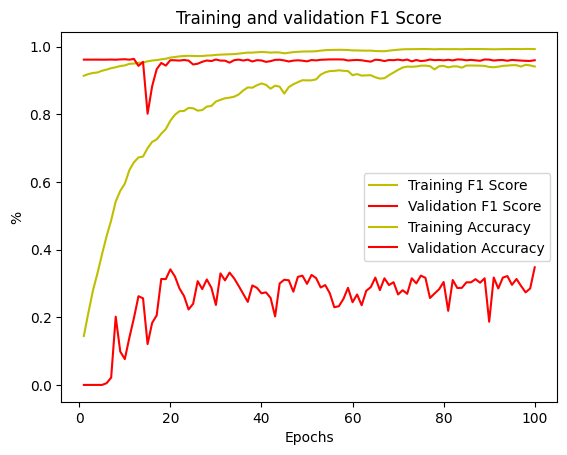

In [26]:
#plot the training and validation F1-Score and Accuracy at each epoch
f1_m = history.history['f1_m']
val_f1_m = history.history['val_f1_m']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(f1_m) + 1)

# Plotar as linhas
plt.plot(epochs, f1_m, 'y', label='Training F1 Score')
plt.plot(epochs, val_f1_m, 'r', label='Validation F1 Score')
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')

# Adicionar os valores numéricos aos pontos desejados
#for i, f1 in enumerate(f1_m):
#    plt.text(epochs[i], f1, f'{f1:.2f}', ha='center', va='bottom')
#for i, val_f1 in enumerate(val_f1_m):
#    plt.text(epochs[i], val_f1, f'{val_f1:.2f}', ha='center', va='bottom')
#for i, accuracy in enumerate(acc):
#    plt.text(epochs[i], accuracy, f'{accuracy:.2f}', ha='center', va='top')
#for i, val_accuracy in enumerate(val_acc):
#    plt.text(epochs[i], val_accuracy, f'{val_accuracy:.2f}', ha='center', va='top')

plt.title('Training and validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend()
plt.show()

## Predict

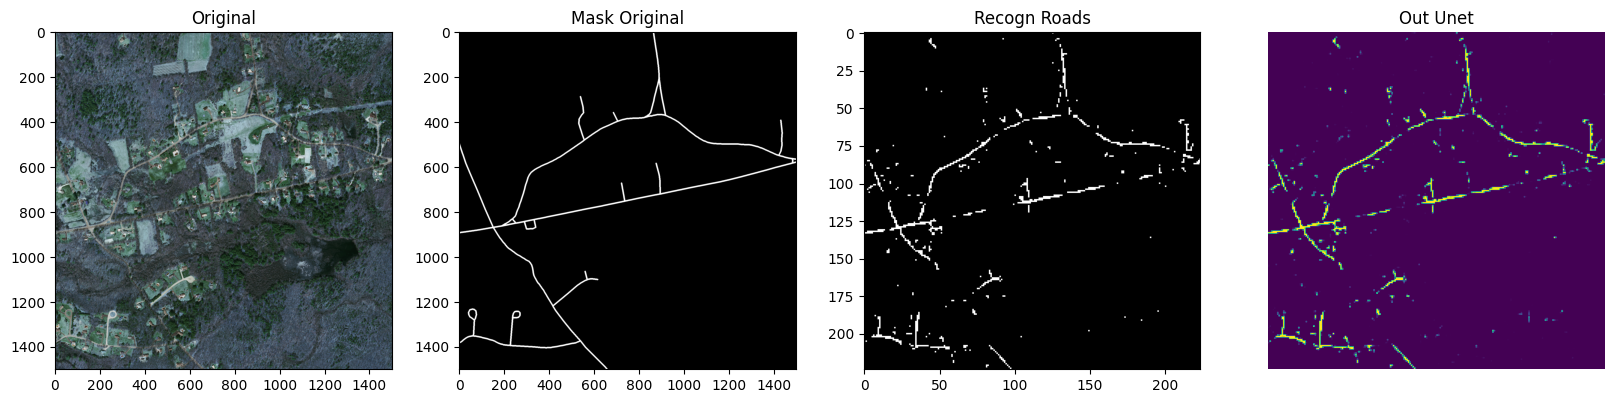

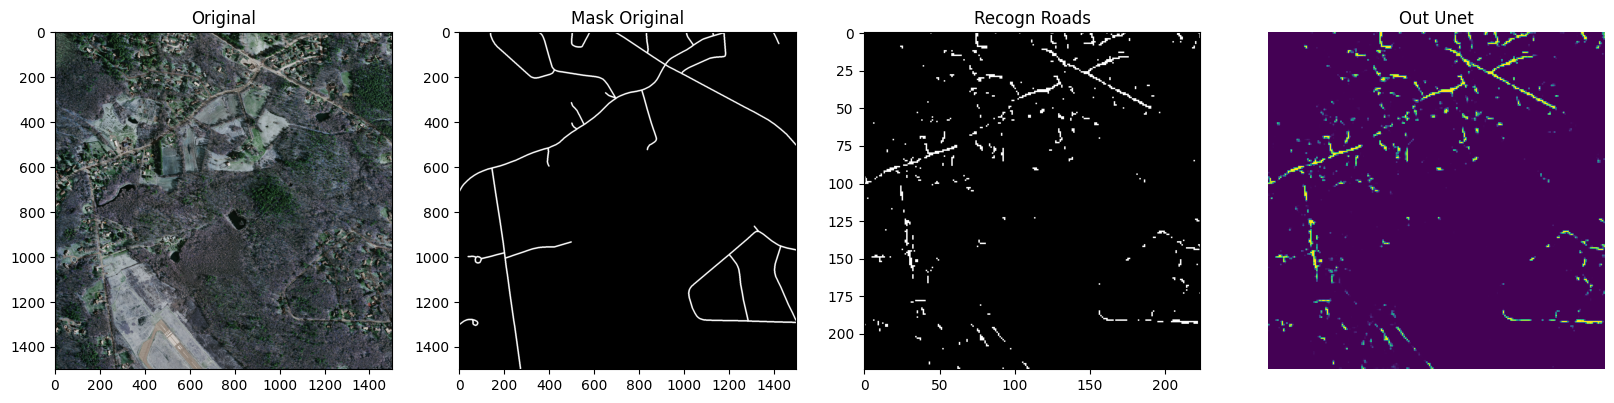

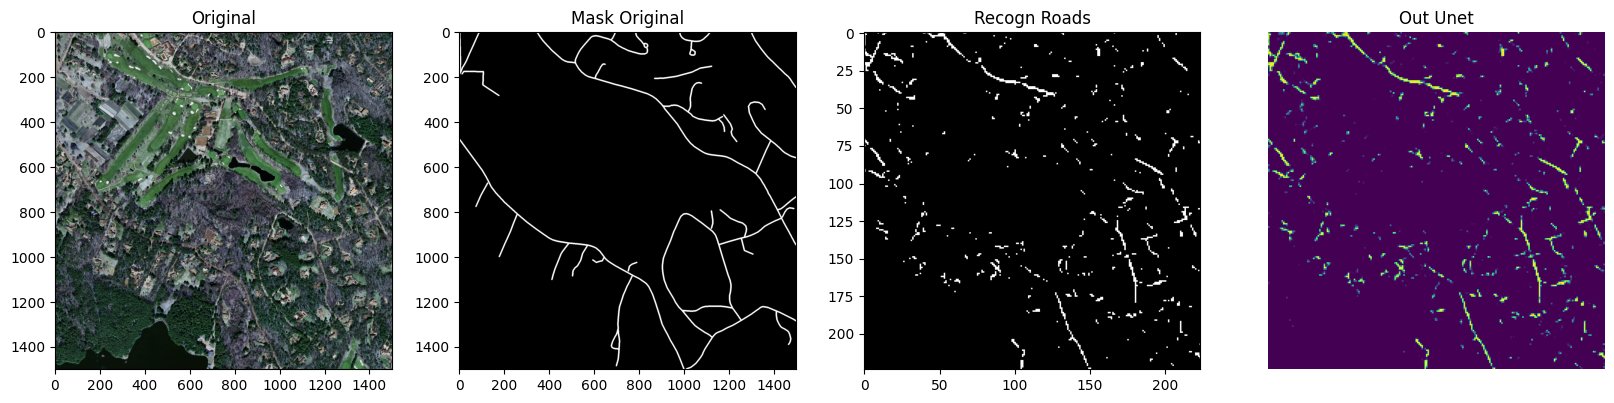

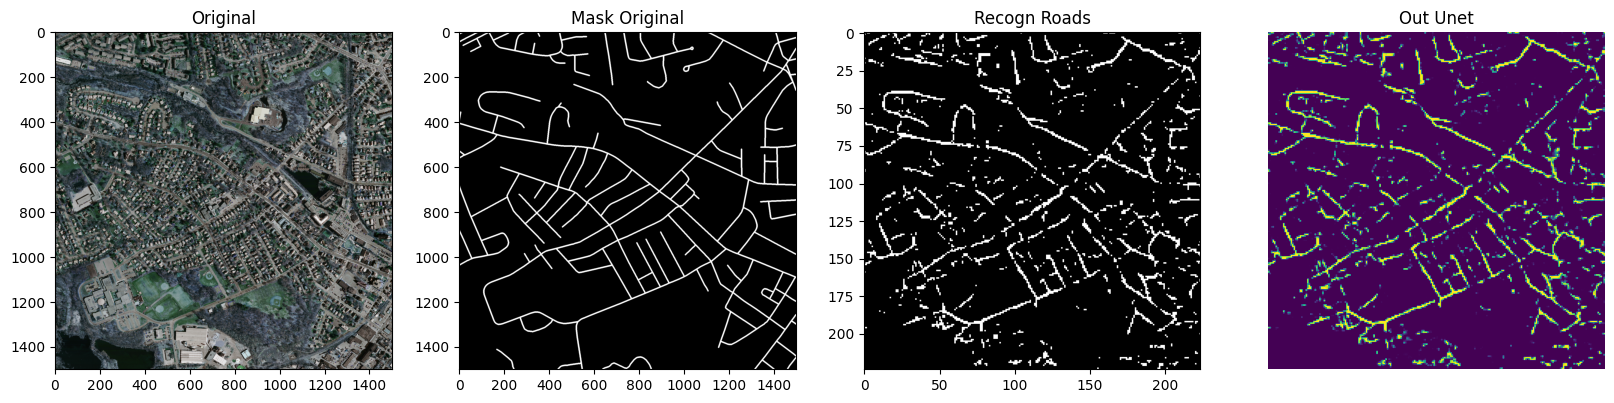

In [27]:
recogn_test_image(Perc_DS)

A little bit noisy but it is great. With more epochs of training and bigger images input images we should be able to achieve better resutlts.